### Using the temporal nets to analyse the burst dynamics of links 

Analysis of the burst dynamics of each link for each frequency band and stage of the ODRT.

In [1]:
# Adding GDa to path
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.spectral_analysis             import filtering, time_frequency
from   GDa.misc.create_grids             import create_stages_time_grid
from   GDa.net.util                      import compute_coherence_thresholds
from   tqdm                              import tqdm
from   joblib                            import Parallel, delayed
from   GDa.graphics.plot_brain_sketch    import *
from   GDa.misc.create_grids             import create_stages_time_grid
from   GDa.session                       import session
from   scipy                             import stats
import numpy             as     np
import matplotlib.pyplot as     plt
import scipy.signal
import time

In [2]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths        = find_activation_sequences(spike_train)
    # Average, std, total, number of activation length  
    mu, sigma, tt, nb  = act_lengths.mean(), act_lengths.std(), \
                         np.sum(spike_train)/len(spike_train), len(act_lengths)/(len(spike_train)/2)
                      
    return mu, sigma, sigma/mu, tt, nb

# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Bands names
bands  = [r'band 1', r'band 2', r'band 3', r'band 4', r'band 5']
stages = ['baseline', 'cue', 'delay', 'match']

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials, Time]. For Lucy the frequency bands analysed are:

- band $1$  = [0.1,6]  Hz;
- band $2$  = [6,14]   Hz;
- band $3$  = [14,26]  Hz;
- band $4$  = [26,42]  Hz;
- band $5$  = [42,80]  Hz;

The __temporal_network__ class can also be instantiated by setting threshold as __True__ this will automatically threshold the super-tensor.

In [3]:
# Instantiating a temporal network object without thresholding the data
net =  temporal_network(data_raw_path = '../GrayLab/', tensor_raw_path = '../super_tensors/', monkey='lucy', 
                        session=1, date='150128', trim_borders=True, wt=(20,30), threshold=True, 
                        relative=True, q=0.8)

Computing coherence thresholds


100%|██████████| 5/5 [00:55<00:00, 11.08s/it]


In [4]:
net.coh_thr

<xarray.DataArray (links: 1176, bands: 5)>
array([[0.89418699, 0.83883577, 0.68078089, 0.58308289, 0.33899995],
       [0.90961679, 0.81841732, 0.71057775, 0.57526592, 0.32939366],
       [0.91497197, 0.82300652, 0.69287509, 0.57301191, 0.32541949],
       ...,
       [0.91814165, 0.87129961, 0.66350306, 0.52226509, 0.27372213],
       [0.97032896, 0.91630333, 0.72497355, 0.57335976, 0.39492388],
       [0.9772041 , 0.93167953, 0.75417152, 0.59017962, 0.40640898]])
Dimensions without coordinates: links, bands

To use the Python package networkx or igraph to compute network theory quantities it is necessary to instantiate a __Graph__ object, to do so we have to provide an adjacency matrix to the __Graph__ method. Note that the super tensor is the edge representation of the network, but we can convert it to an adjacency matrix by calling the methdo __convert_to_adjacency__ in the class __temporal_network__. This method will create the variable __A__ inside the object.

In [5]:
net.convert_to_adjacency()

#### X, Y coordinates of each node

In [6]:
xy   = scipy.io.loadmat('../Brain Areas/lucy_brainsketch_xy.mat')['xy'] # Channels coordinates
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

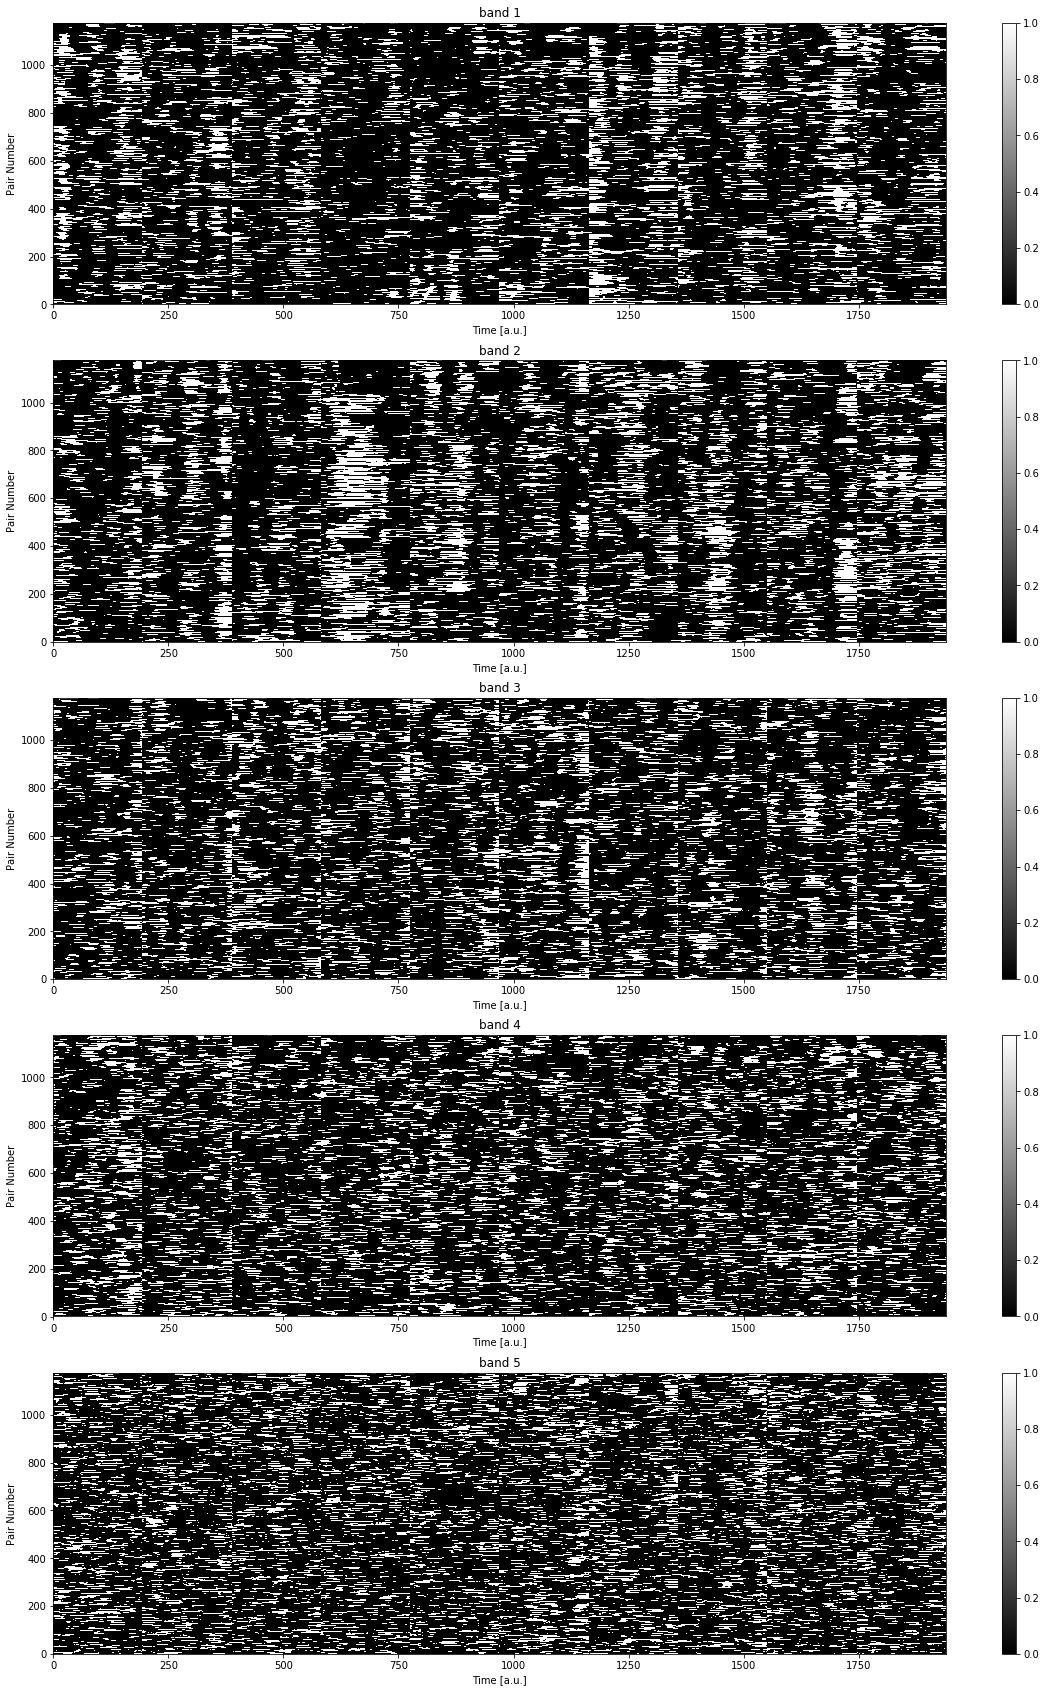

In [7]:
plt.figure(figsize=(20,30))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(net.super_tensor[:,i,:10,:].values.reshape(net.super_tensor.shape[0],10*len(net.tarray)), 
               aspect = 'auto', cmap = 'gray', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.colorbar()
    plt.ylabel('Pair Number')
    plt.xlabel('Time [a.u.]')
    plt.title(bands[i])

### Filtering trials

If one wants to analyse specific trials, for instance trials were the ODRT was performed, the __trials_info__ dictionary can be used to do so. To illustrate, let's work only with trials of type 1, were the monkey was successful.

In [8]:
net.trial_info.head()

trial_index  behavioral_response  match_image  match_location  match_on  \
0            0                  NaN          NaN             NaN    2654.0   
1            1                  1.0          2.0             7.0    2824.0   
2            2                  1.0          5.0             8.0    2946.0   
3            3                  1.0          2.0             3.0    2954.0   
4            9                  1.0          4.0             7.0    2759.0   

   nonmatch_image  nonmatch_location  num_trials  reaction_time  sample_image  \
0             NaN                NaN      1006.0            NaN           NaN   
1             4.0                3.0      1006.0          145.0           2.0   
2             4.0                4.0      1006.0          205.0           5.0   
3             3.0                7.0      1006.0          260.0           2.0   
4             2.0                3.0      1006.0          178.0           4.0   

   sample_location  sample_off  sample_on  trial_type  
0              NaN      1495.0      975.0         2.0  
1              1.0      1371.0      851.0         1.0  
2              1.0      1600.0     1093.0         1.0  
3              1.0      1528.0     1021.0         1.0  
4              1.0      1480.0      973.0         1.0

In [9]:
# Getting the number for ODRT trials
filtered_trials     = net.trial_info[(net.trial_info['trial_type']==1.0)\
                                   & (net.trial_info['behavioral_response']==1.0)].trial_index.values
# Getting the index for those trials
filtered_trials_idx = net.trial_info[(net.trial_info['trial_type']==1.0)\
                                   & (net.trial_info['behavioral_response']==1.0)].index.values

In [10]:
# Filter supertensor for the desired trials
filtered_super_tensor = net.super_tensor.sel(trials = filtered_trials)
# Filter adj for the desired trials
filtered_adjacency = net.A.sel(trials = filtered_trials)

#### Mask to track observations within a task-stage

In [11]:
# Creating stages mask with trials concatenated
s_mask = create_stages_time_grid(net.super_tensor.attrs['t_cue_on'][filtered_trials_idx],
                                 net.super_tensor.attrs['t_cue_off'][filtered_trials_idx],
                                 net.super_tensor.attrs['t_match_on'][filtered_trials_idx], 
                                 net.super_tensor.attrs['fsample'],
                                 net.tarray, len(filtered_trials_idx), flatten=True)

### CV distribution per band and task stage

In [12]:
# Stack trials and time in the super tensor
STb = filtered_super_tensor.stack(observations=("trials","time"))
STb

<xarray.DataArray (links: 1176, bands: 5, observations: 104760)>
array([[[ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * observations  (observations) MultiIndex
  - trials        (observations) int64 1 1 1 1 1 1 1 ... 886 886 886 886 886 886
  - time          (observations) float64 -0.35 -0.335 -0.32 ... 2.515 2.53 2.545
Dimensions without coordinates: links, bands
Attributes:
    nT:               750
    areas:            [b'a46V' b'a24c' b'a46D' b'F7' b'a9/46D' b'a8M' b'a8r' ...
    channels_labels:  [  1   4   9  13  16  17  22  23  26  27  29  34  39  4...
    fsample:          1000.0
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 ...
    nC:               49
    nP:               1176
    pairs:            [[ 0  1]\n [ 0  2]\n [ 1  2]\n ...\n [45 48]\n [46 48]\...
    stim:             [nan  2.  5.  2.  4.  2.  4.  2.  5.  1.  3.  5.  5.  1...
    t_cue_off:        [1495. 1371. 1600. 1528. 1480. 1489. 1473. 1341. 1553. ...
    t_cue_on:         [ 975.  851. 1093. 1021.  973.  969.  966.  835. 1046. ...
    t_match_on:       [2654. 2824. 2946. 2954. 2759. 2676. 2699. 2474. 2846. ...

100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


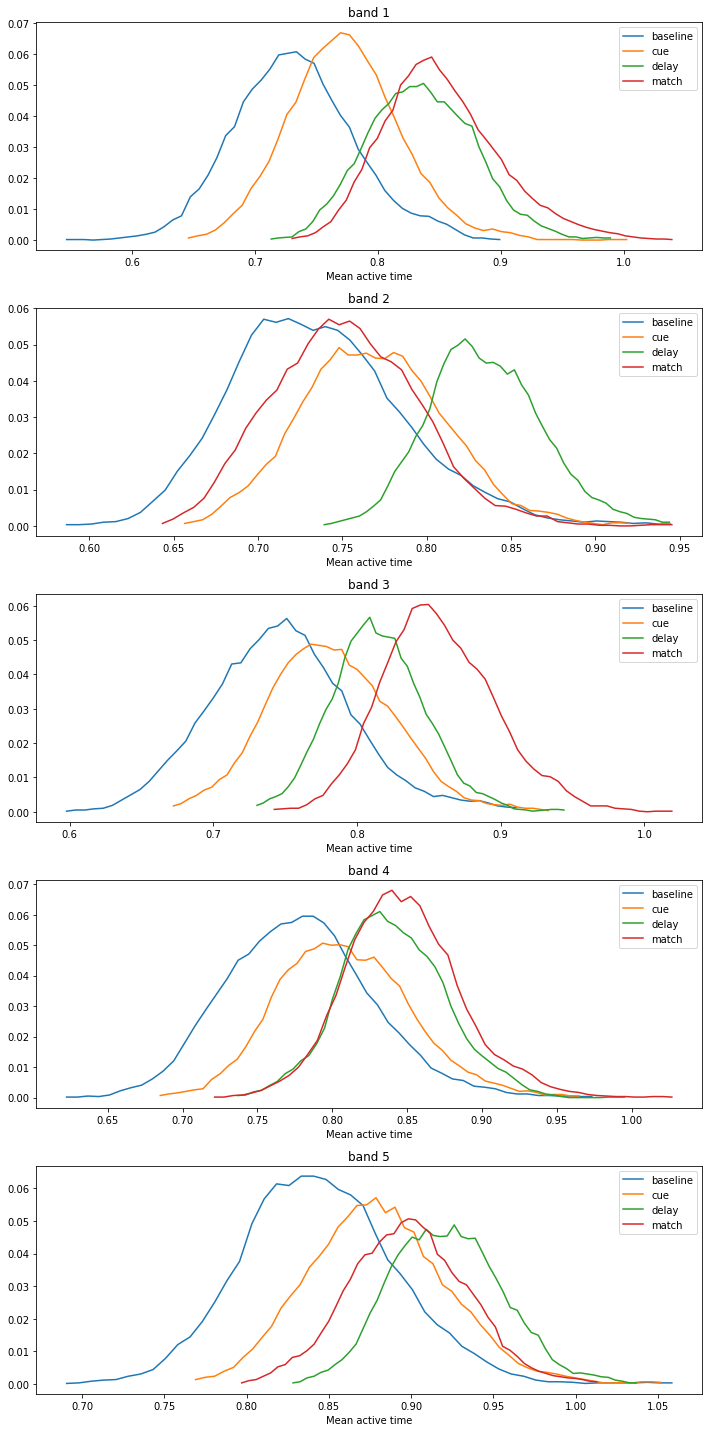

In [14]:
plt.figure(figsize=(10,20))
for i in tqdm( range(len(net.bands)) ):
    b  = {}
    plt.subplot(5,1,i+1)
    for j,s in zip(range(len(stages)),stages):
        b[stages[j]]  = np.zeros([filtered_super_tensor.shape[0], 4])
        b[stages[j]]  = np.apply_along_axis(count_activations, 1, STb[:,i,s_mask[s]])
        aux = b[stages[j]][:,2]
        c, x = np.histogram(aux, 50)
        c    = c/c.sum()
        plt.plot(x[1:], smooth(c,5), label = stages[j])
    plt.legend()
    plt.xlabel('Mean active time')
    plt.title(bands[i])
plt.tight_layout()

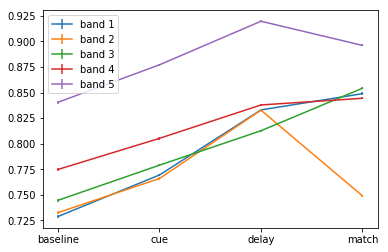

In [15]:
for j in range(len(bands)):
    for i,s in zip(range(len(stages)),stages):
        b[stages[i]]  = np.zeros([STb.shape[0], 3])
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[s]])

    p=b['baseline'][:,2]
    c=b['cue'][:,2]
    d=b['delay'][:,2]
    m=b['match'][:,2]

    plt.errorbar(range(4), [p.mean(), c.mean(), d.mean(), m.mean()], 
                 [p.std()/np.sqrt(1176), c.std()/np.sqrt(1176), d.std()/np.sqrt(1176), m.std()/np.sqrt(1176)])
    plt.xticks(range(4), ['baseline', 'cue', 'delay', 'match'])
plt.legend(bands)

In [17]:
CVm = np.zeros([49, 49, len(bands), len(stages)]) 
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        aux  = np.apply_along_axis( count_activations, 1, STb[:,k,s_mask[stages[i]]])
        for j in range( net.session_info['pairs'].shape[0]):
            CVm[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], k, i] = aux[j,2]

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


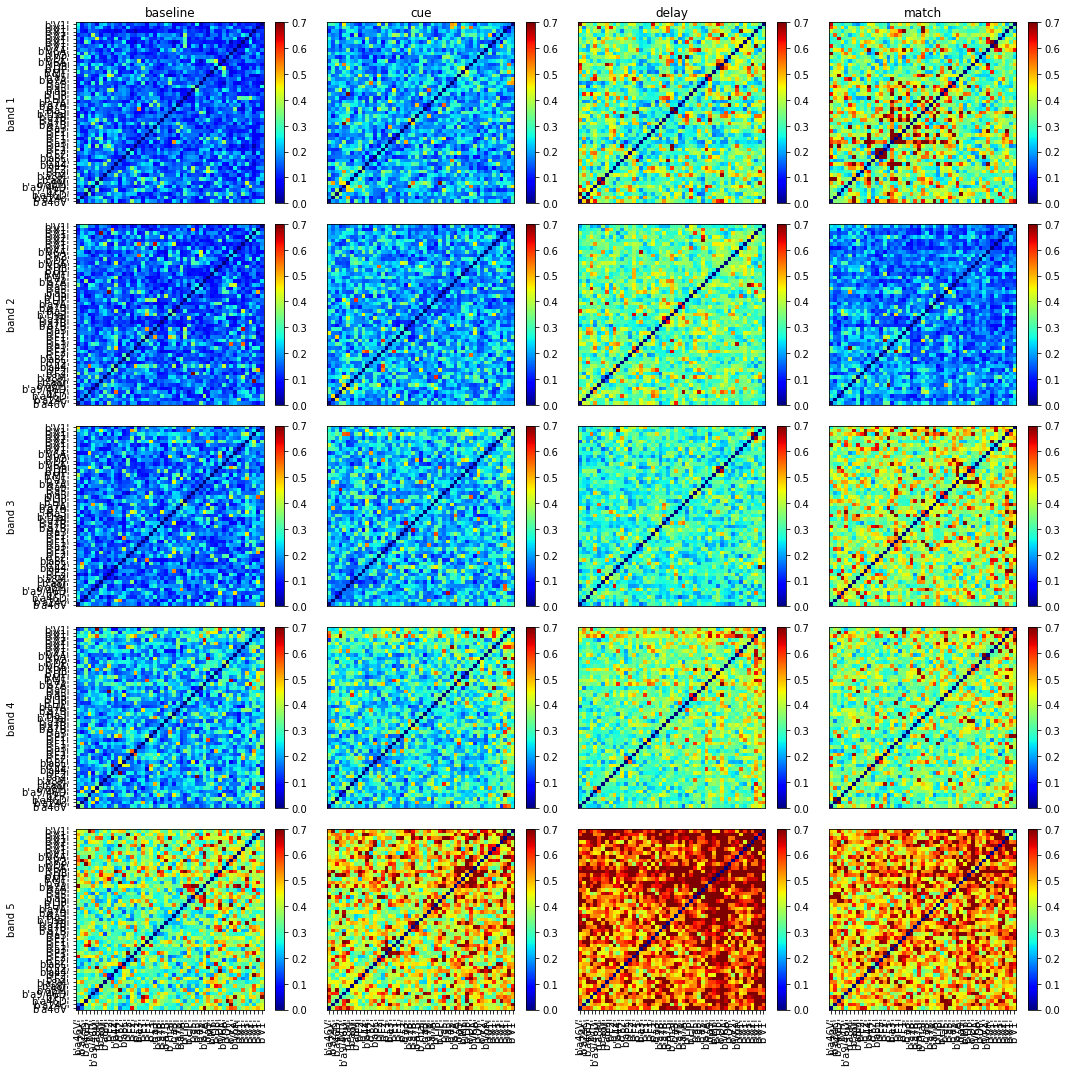

In [18]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(bands),len(stages),count)
        aux = (CVm[:,:,k,i]+CVm[:,:,k,i].T) 
        plt.imshow(aux**6, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=.7);plt.colorbar()
        if stages[i] == 'baseline': plt.yticks(range(49), net.session_info['areas'])
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), net.session_info['areas'], rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[k])
        #plt.colorbar()
        count+=1
plt.tight_layout()

#### Top 20 most active links

100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


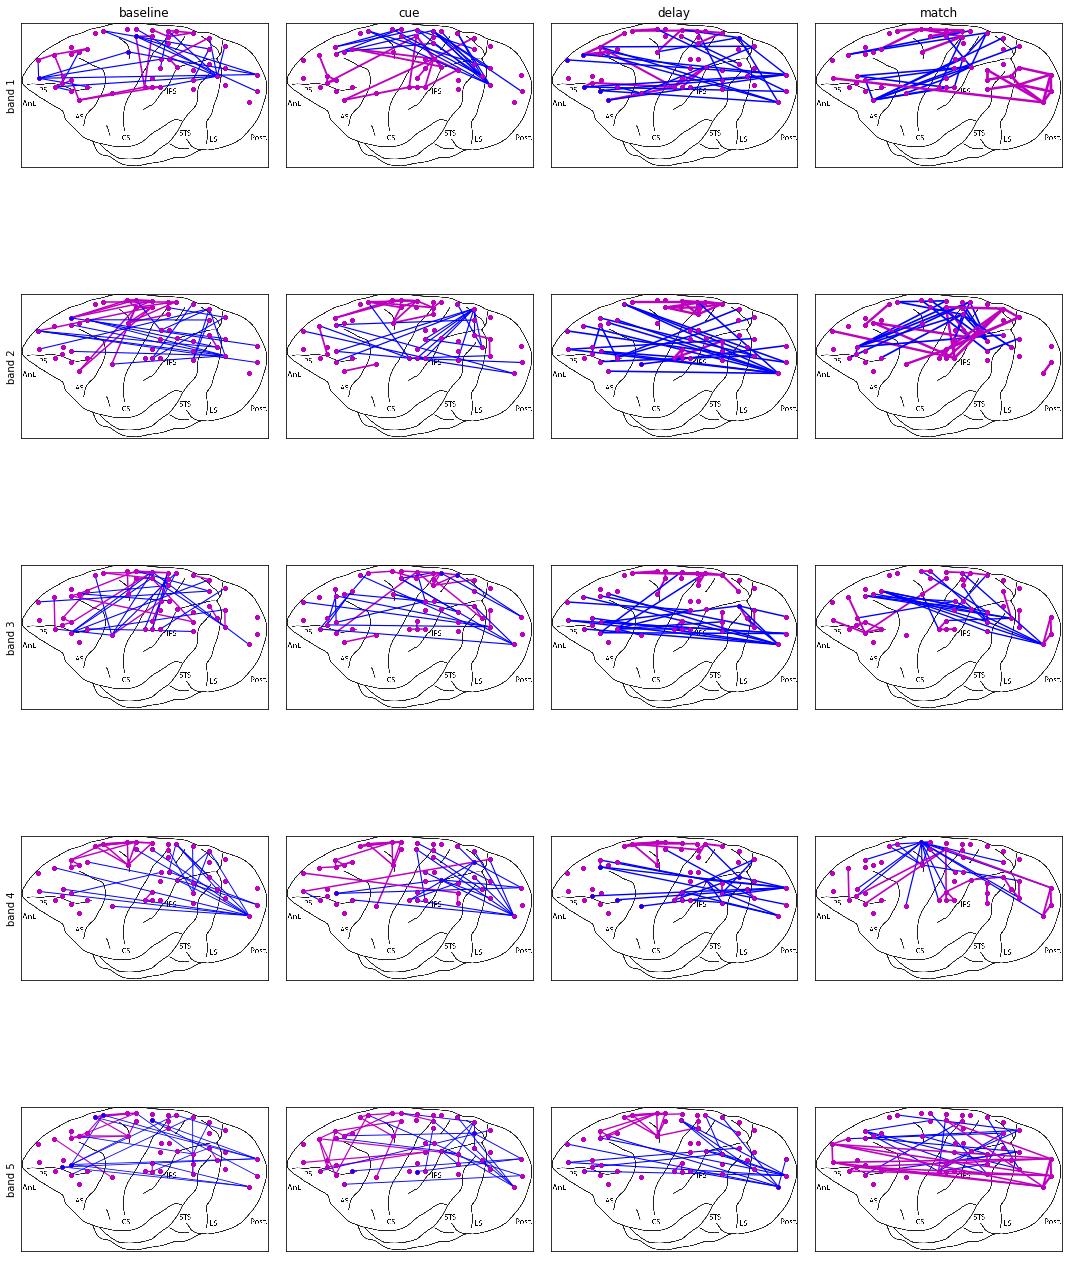

In [19]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,0].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,0].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,0].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,0].shape[0])
        idx2[bot] = 1
        #
        aux = b[stages[i]][:,0]*idx1 - b[stages[i]][:,0]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               .1*aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Top 20 most busrty links

100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


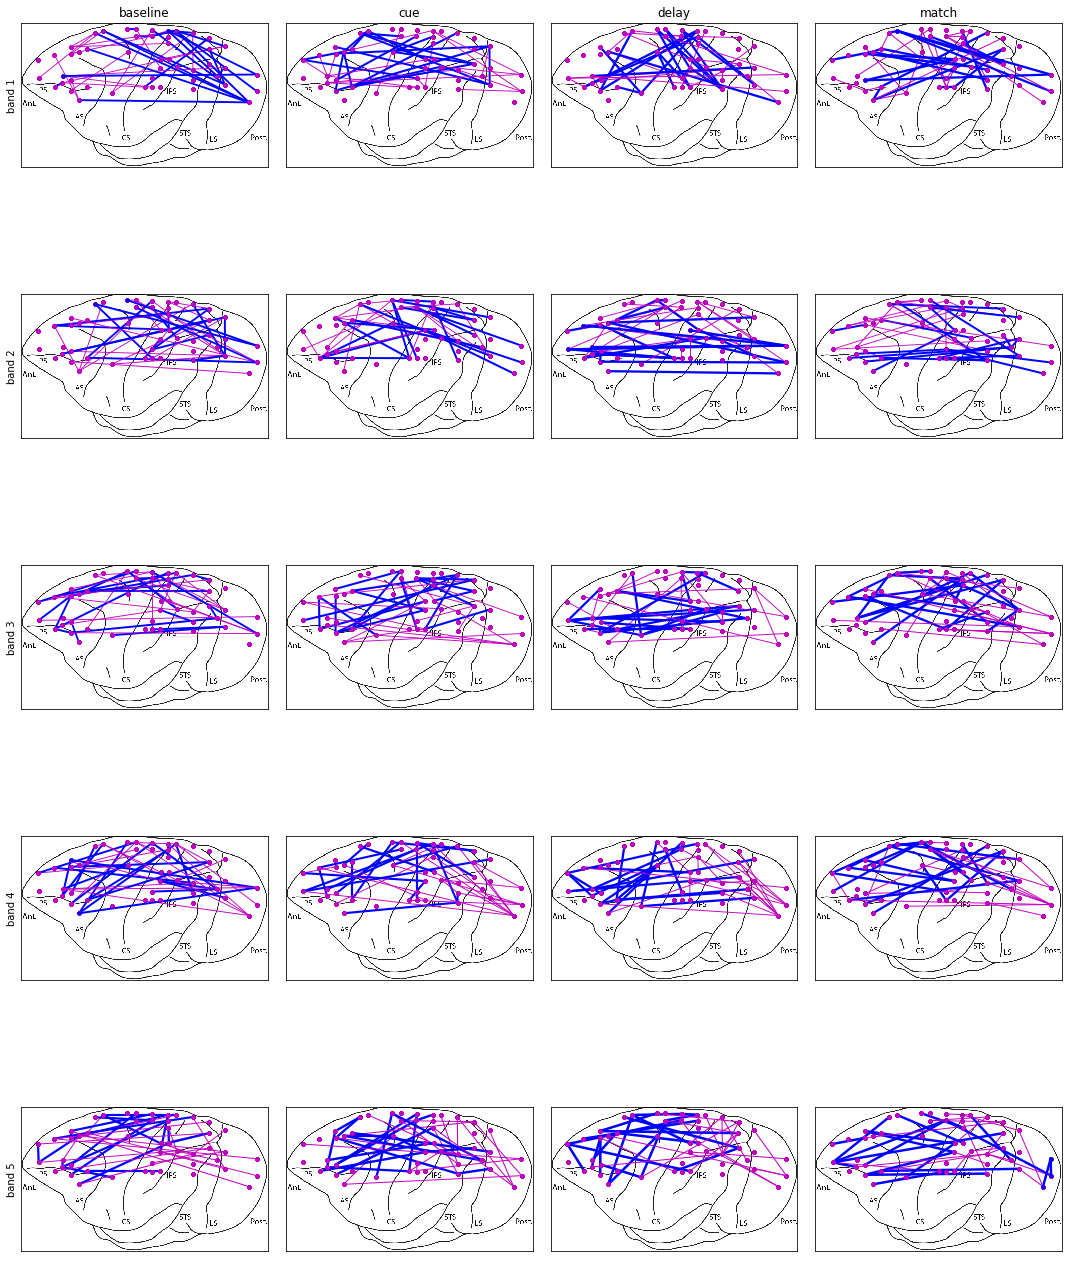

In [20]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,2].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,2].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,2].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,2].shape[0])
        idx2[bot] = 1
        #
        aux = 3*b[stages[i]][:,2]*idx1 - b[stages[i]][:,2]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Burstness vs active time

100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


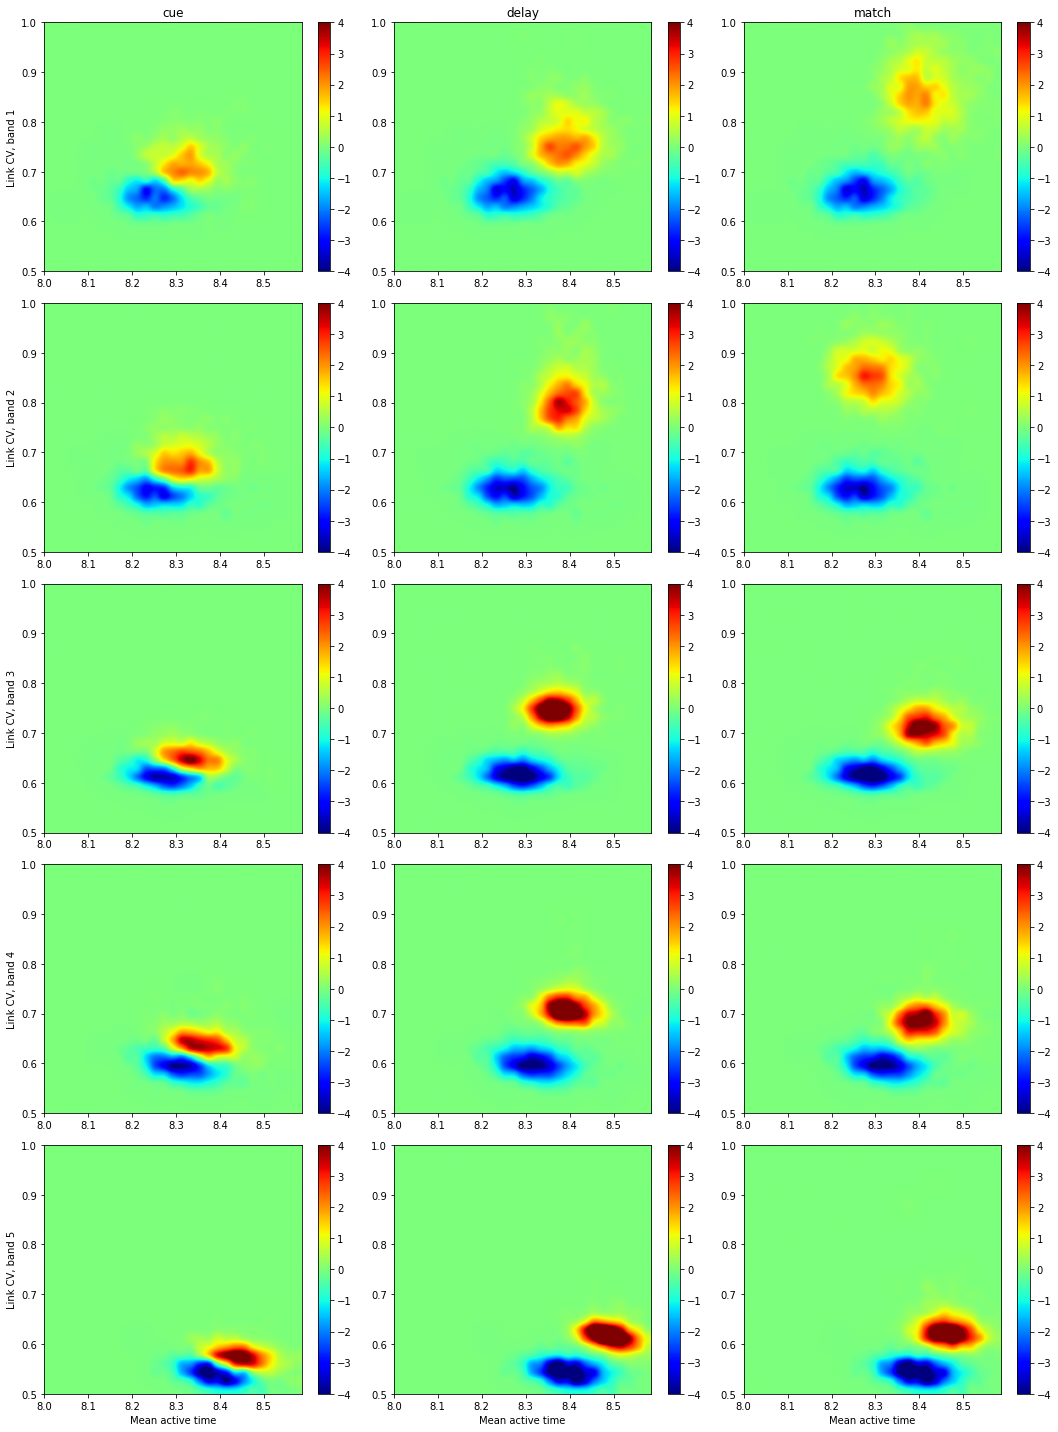

In [21]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    # Baseline
    b['baseline']  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask['baseline']])
    Hb, xb, yb = np.histogram2d(b['baseline'][:,0], b['baseline'][:,2], 
                            bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True  )
    for i in range(1,len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        # Plotting top links
        plt.subplot(len(bands), len(stages)-1, count)
        #plt.hist2d(b[stages[i]][:,0], b[stages[i]][:,2], bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)] )
        H, xb, yb = np.histogram2d(b[stages[i]][:,0], b[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-4, vmax=4)
        plt.colorbar()
        if j == 4: plt.xlabel('Mean active time')
        if j == 0: plt.title(stages[i])
        if stages[i] == 'cue': plt.ylabel('Link CV, ' + bands[j])
        count += 1
plt.tight_layout()

#### Dimensinality reduction on the raster plots

In [22]:
from MulticoreTSNE    import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

In [23]:
Y = TSNE(n_components=2, metric='hamming', perplexity=30.0, n_jobs=40).fit_transform(STb[:,1,:100*194].T)

/home/vinicius/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


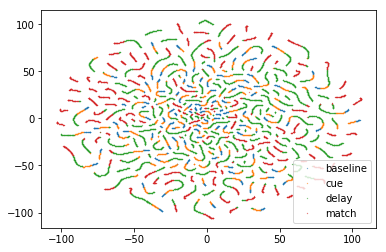

In [24]:
for i in range(len(stages)):
    plt.plot(Y[s_mask[stages[i]][:100*194],0], Y[s_mask[stages[i]][:100*194],1], '.', ms=0.5, label = stages[i])
plt.legend()

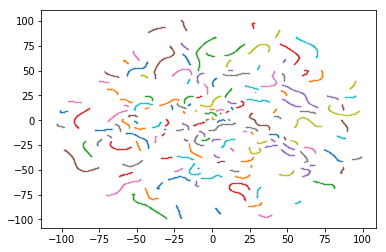

In [25]:
# To check if each worm is a trial (each color is a different trial)
for i in range(50):
    plt.plot(Y[i*194:(i+1)*194,0], Y[i*194:(i+1)*194,1], '.', ms=0.5,)

#### Burstiness vs electrode distance

100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


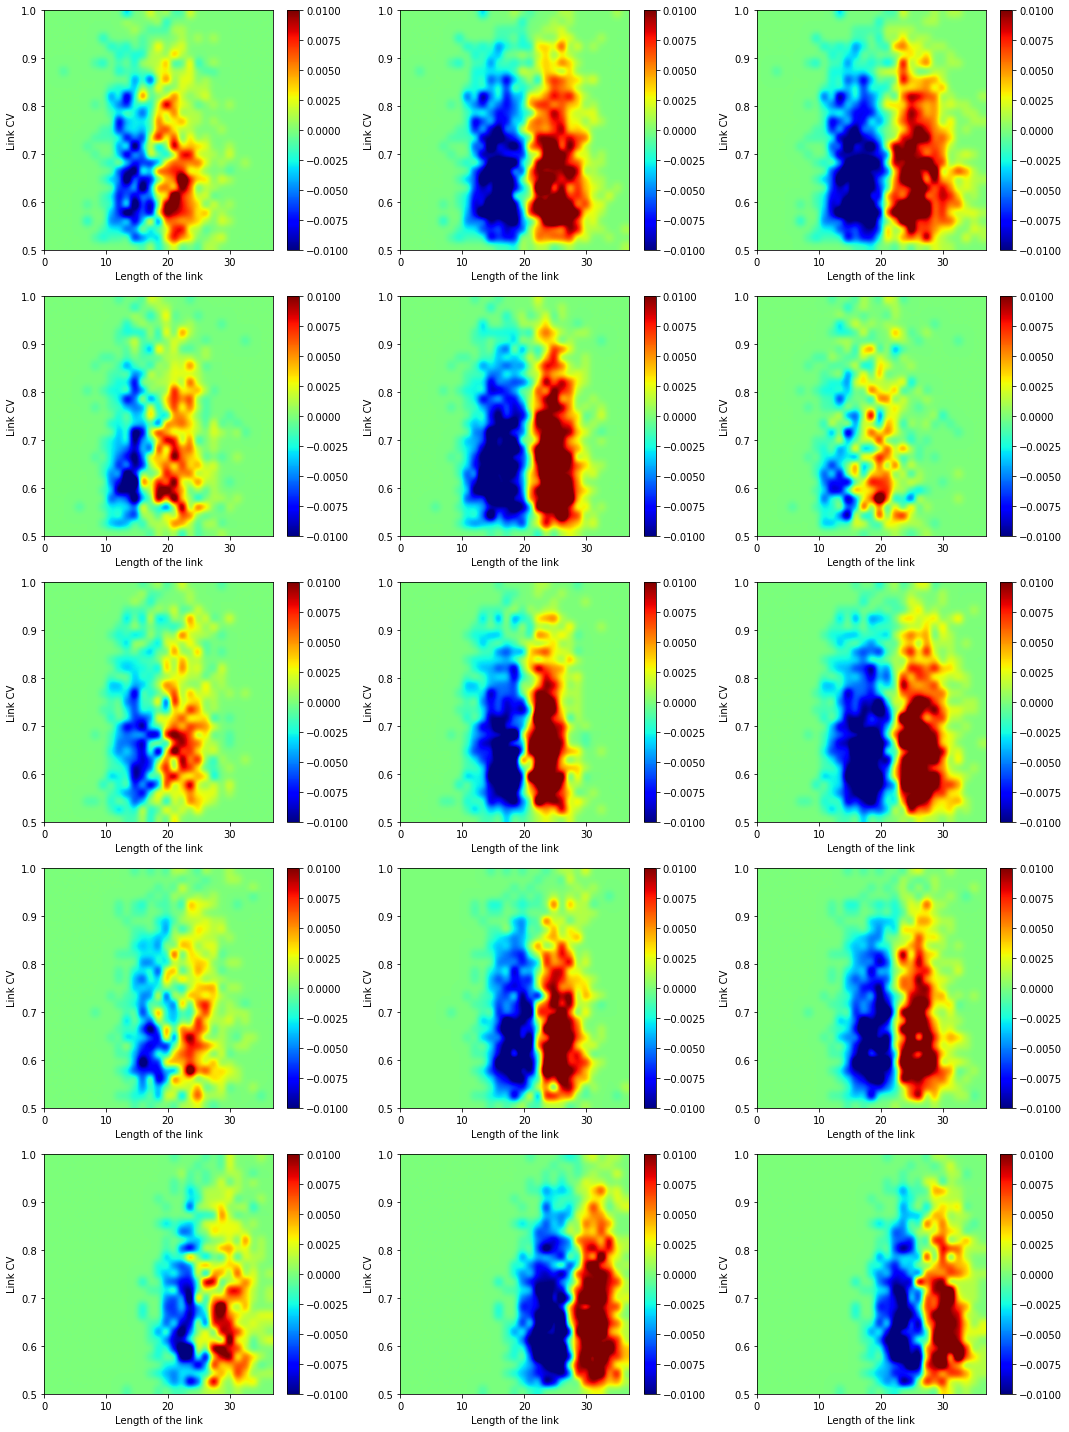

In [26]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    # Baseline
    b['baseline']  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask['baseline']])
    Hb,xb,yb=np.histogram2d(d_eu, b['baseline'][:,2], 
                            bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                            density=True)
    for i in range(1, len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        # Plotting
        plt.subplot(len(bands), len(stages)-1, count)
        H,xb,yb=np.histogram2d(d_eu, b[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        plt.imshow(H-Hb, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-0.01, vmax=0.01)
        plt.ylabel('Link CV')
        plt.colorbar()
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()

#### Links' correlation

In [27]:
nP       = int( scipy.special.comb(net.session_info['nP'], 2) )
i, j     = np.tril_indices(net.session_info['nP'], k = -1)
pairs    = np.array([j,i]).T

In [28]:
CCij = np.zeros([len(net.bands), net.session_info['nP'],net.session_info['nP'],len(stages)])
for b in tqdm( range(len(net.bands)) ):
    for s in range(len(stages)):
        CCij[b,:,:,s] = np.corrcoef(STb[:,b,s_mask[stages[s]]].values, rowvar=True) #CCij[b,j,i,s] = np.corrcoef(aux[i],aux[j])[0,1]# / L

100%|██████████| 5/5 [00:26<00:00,  5.36s/it]


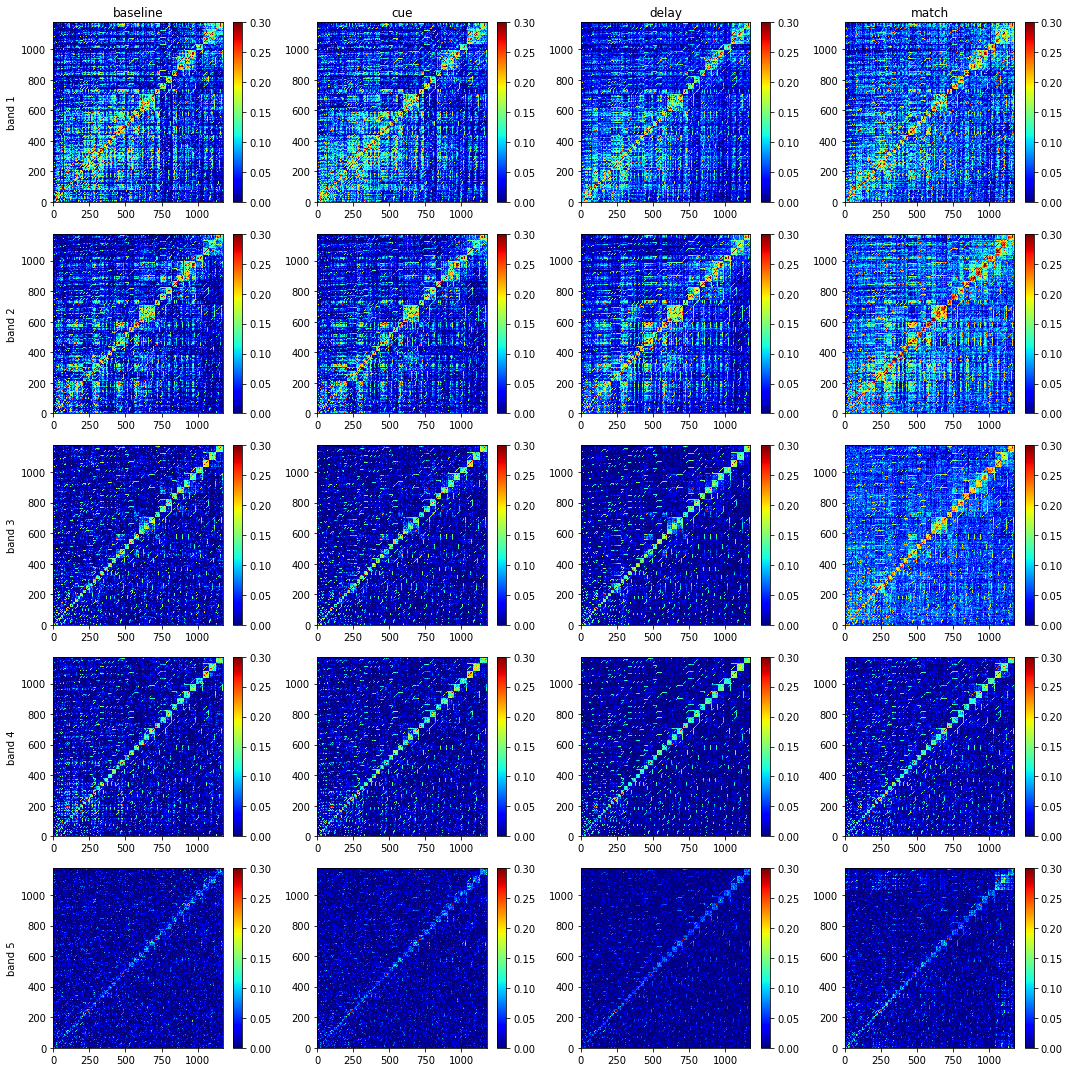

In [29]:
plt.figure(figsize=(15,15))
count = 1
for b in range(len(net.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        plt.imshow(CCij[b,:,:,i], aspect='auto', cmap='jet', origin='lower', 
                   vmin=0, vmax=.3)
        if b == 0: plt.title(stages[i])
        if i == 0: plt.ylabel(bands[b])
        plt.colorbar()
        count+=1
plt.tight_layout()

### Cross-frequency coupling

### Comparison with fixation

In [30]:
# Getting the number for ODRT trials
filtered_trials_fix     = net.trial_info[(net.trial_info['trial_type']==2.0)].trial_index.values
# Getting the index for those trials
filtered_trials_idx_fix = net.trial_info[(net.trial_info['trial_type']==2.0)].index.values

In [31]:
# Filter supertensor for the desired trials
filtered_super_tensor_fix = net.super_tensor.sel(trials = filtered_trials_fix)
# Filter adj for the desired trials
filtered_adjacency_fix = net.A.sel(trials = filtered_trials_fix)

In [32]:
# Mask to track each stage of the ODRT
s_mask_fix = create_stages_time_grid(net.super_tensor.attrs['t_cue_on'][filtered_trials_idx_fix],
                                 net.super_tensor.attrs['t_cue_off'][filtered_trials_idx_fix],
                                 net.super_tensor.attrs['t_match_on'][filtered_trials_idx_fix], 
                                 net.super_tensor.attrs['fsample'],
                                 net.tarray, len(filtered_trials_idx_fix), flatten=True)

In [33]:
# Stack trials and time in the super tensor
STb_fix = filtered_super_tensor_fix.stack(observations=("trials","time"))
STb_fix

<xarray.DataArray (links: 1176, bands: 5, observations: 14744)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [ True, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * observations  (observations) MultiIndex
  - trials        (observations) int64 0 0 0 0 0 0 0 ... 882 882 882 882 882 882
  - time          (observations) float64 -0.35 -0.335 -0.32 ... 2.515 2.53 2.545
Dimensions without coordinates: links, bands
Attributes:
    nT:               750
    areas:            [b'a46V' b'a24c' b'a46D' b'F7' b'a9/46D' b'a8M' b'a8r' ...
    channels_labels:  [  1   4   9  13  16  17  22  23  26  27  29  34  39  4...
    fsample:          1000.0
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 ...
    nC:               49
    nP:               1176
    pairs:            [[ 0  1]\n [ 0  2]\n [ 1  2]\n ...\n [45 48]\n [46 48]\...
    stim:             [nan  2.  5.  2.  4.  2.  4.  2.  5.  1.  3.  5.  5.  1...
    t_cue_off:        [1495. 1371. 1600. 1528. 1480. 1489. 1473. 1341. 1553. ...
    t_cue_on:         [ 975.  851. 1093. 1021.  973.  969.  966.  835. 1046. ...
    t_match_on:       [2654. 2824. 2946. 2954. 2759. 2676. 2699. 2474. 2846. ...

100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


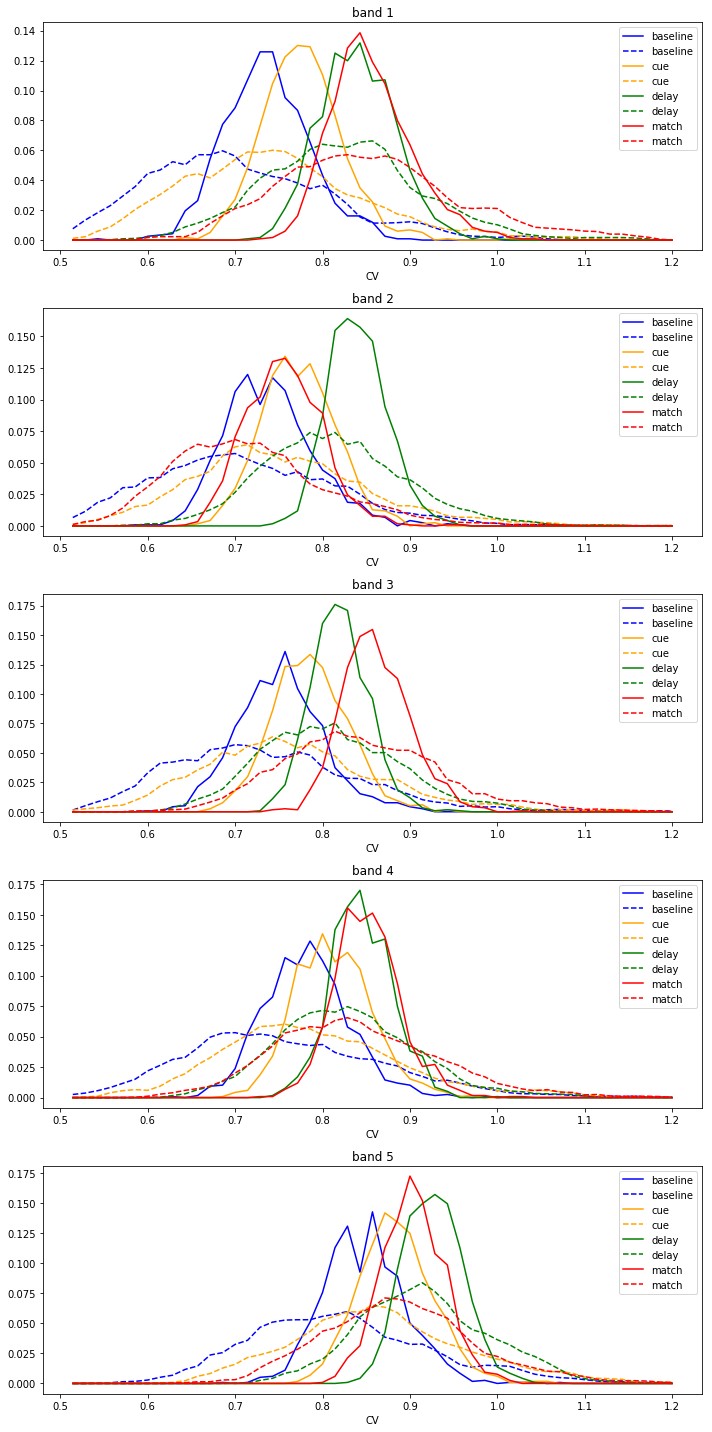

In [34]:
plt.figure(figsize=(10,20))
colors = ['b', 'orange', 'g', 'r']
for i in tqdm( range(len(net.bands)) ):
    b     = {}
    b_fx  = {}
    plt.subplot(5,1,i+1)
    for j in range(len(stages)):
        # ODRT
        b[stages[j]]  = np.zeros([STb.shape[0], 3])
        b[stages[j]]  = np.apply_along_axis(count_activations, 1, STb[:,i,s_mask[stages[j]]])
        aux  = b[stages[j]][:,1]/b[stages[j]][:,0]
        c, x = np.histogram(aux, np.linspace(0.5,1.2,50))
        c    = c/c.sum()
        plt.plot(x[1:], c, label = stages[j], linestyle = '-', color = colors[j])        
        # FIXATION
        b_fx[stages[j]]  = np.zeros([STb_fix.shape[0], 3])
        b_fx[stages[j]]  = np.apply_along_axis(count_activations, 1, STb_fix[:,i,s_mask_fix[stages[j]]])
        aux = b_fx[stages[j]][:,1]/b_fx[stages[j]][:,0]
        c_fx, x_fx = np.histogram(aux, np.linspace(0.5,1.2,50))
        c_fx    = c_fx/c_fx.sum()
        plt.plot(x_fx[1:], smooth(c_fx,3), label = stages[j], linestyle = '--', color = colors[j])
    plt.legend()
    plt.xlabel('CV')
    plt.title(bands[i])
plt.tight_layout()

In [35]:
Y = TSNE(n_components=2, metric='hamming', perplexity=30.0, n_jobs=40).fit_transform(STb_fix[:,1,:100*194].T)

/home/vinicius/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


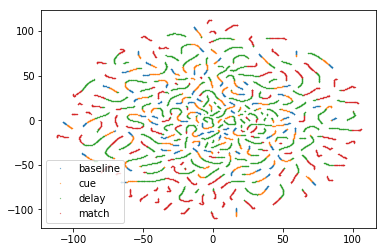

In [36]:
for i in range(len(stages)):
    plt.plot(Y[s_mask_fix[stages[i]][:100*194],0], Y[s_mask_fix[stages[i]][:100*194],1], '.', ms =0.5, label = stages[i])
plt.legend()

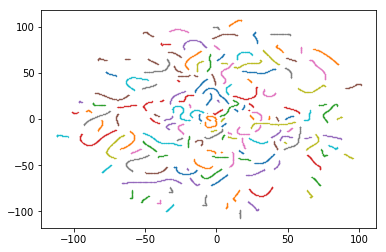

In [37]:
# To check if each worm is a trial (each color is a different trial)
for i in range(50):
    plt.plot(Y[i*194:(i+1)*194,0], Y[i*194:(i+1)*194,1], '.', ms=0.5)

#### Burstness vs active time

100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


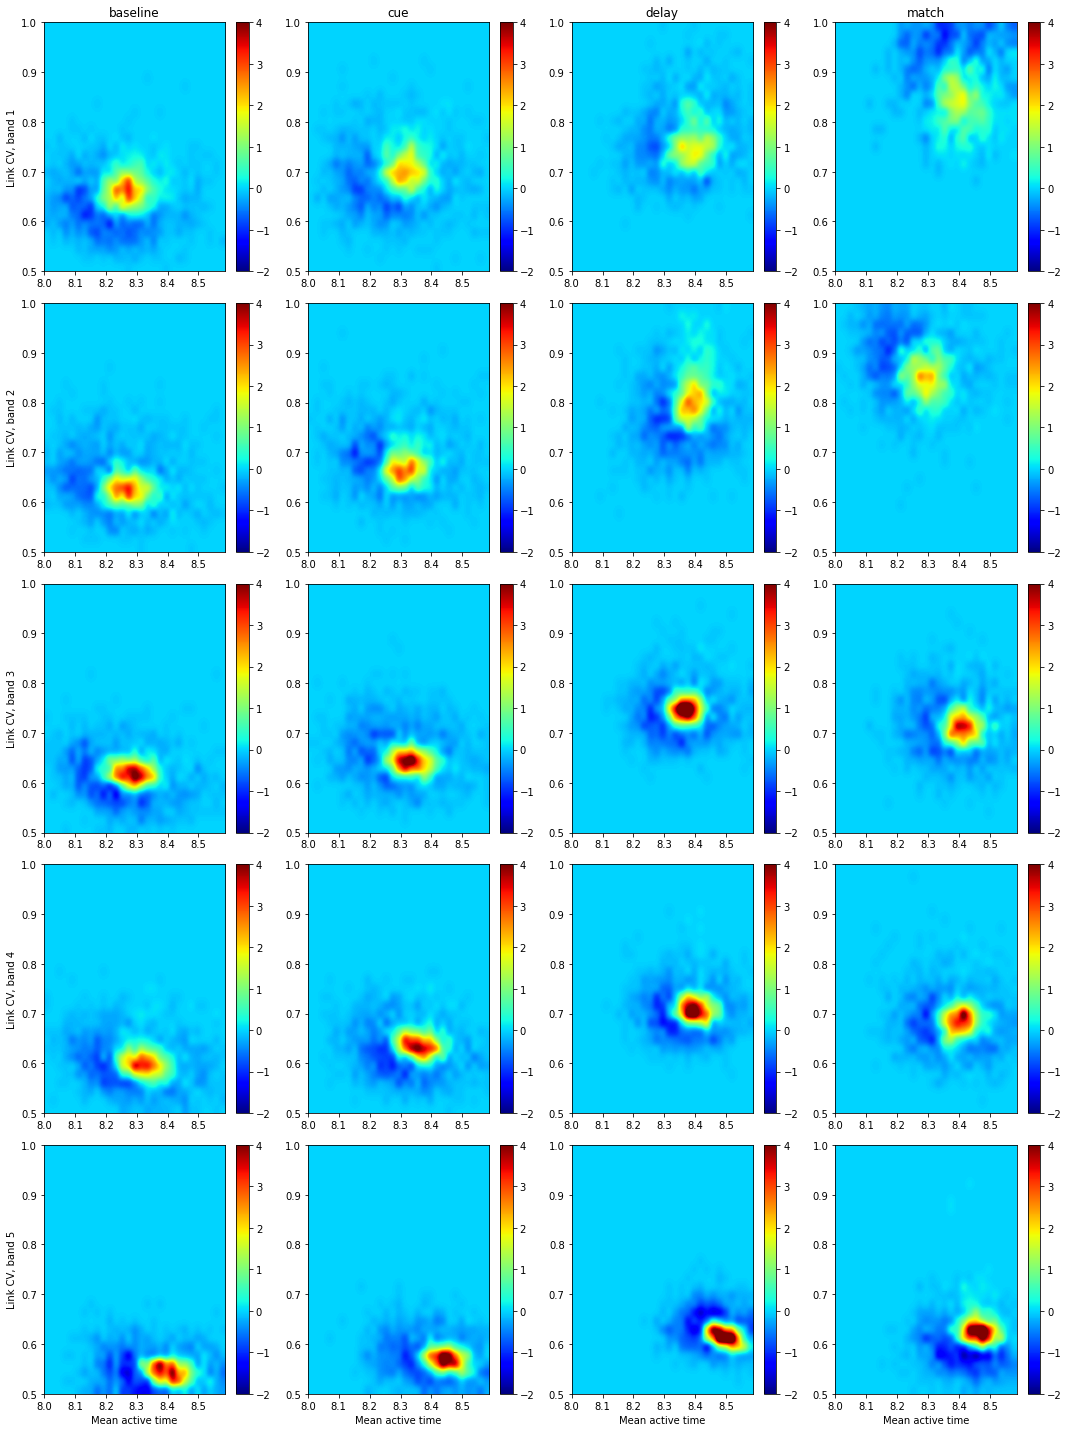

In [38]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b    = {}
    b_fx = {}
    for i in range(len(stages)):   
        plt.subplot(len(bands), len(stages), count)
        # ODRT
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        H, xb, yb = np.histogram2d(b[stages[i]][:,0], b[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        # FIXATION
        b_fx[stages[i]]  = np.apply_along_axis( count_activations, 1, STb_fix[:,j,s_mask_fix[stages[i]]])
        H_fx, xb_fx, yb_fx = np.histogram2d(b_fx[stages[i]][:,0], b_fx[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        # PLOT
        plt.imshow(H-H_fx, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-2, vmax=4)
        plt.colorbar()
        if j == 4: plt.xlabel('Mean active time')
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel('Link CV, ' + bands[j])
        count += 1
plt.tight_layout()

#### Burstiness vs electrode distance

100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


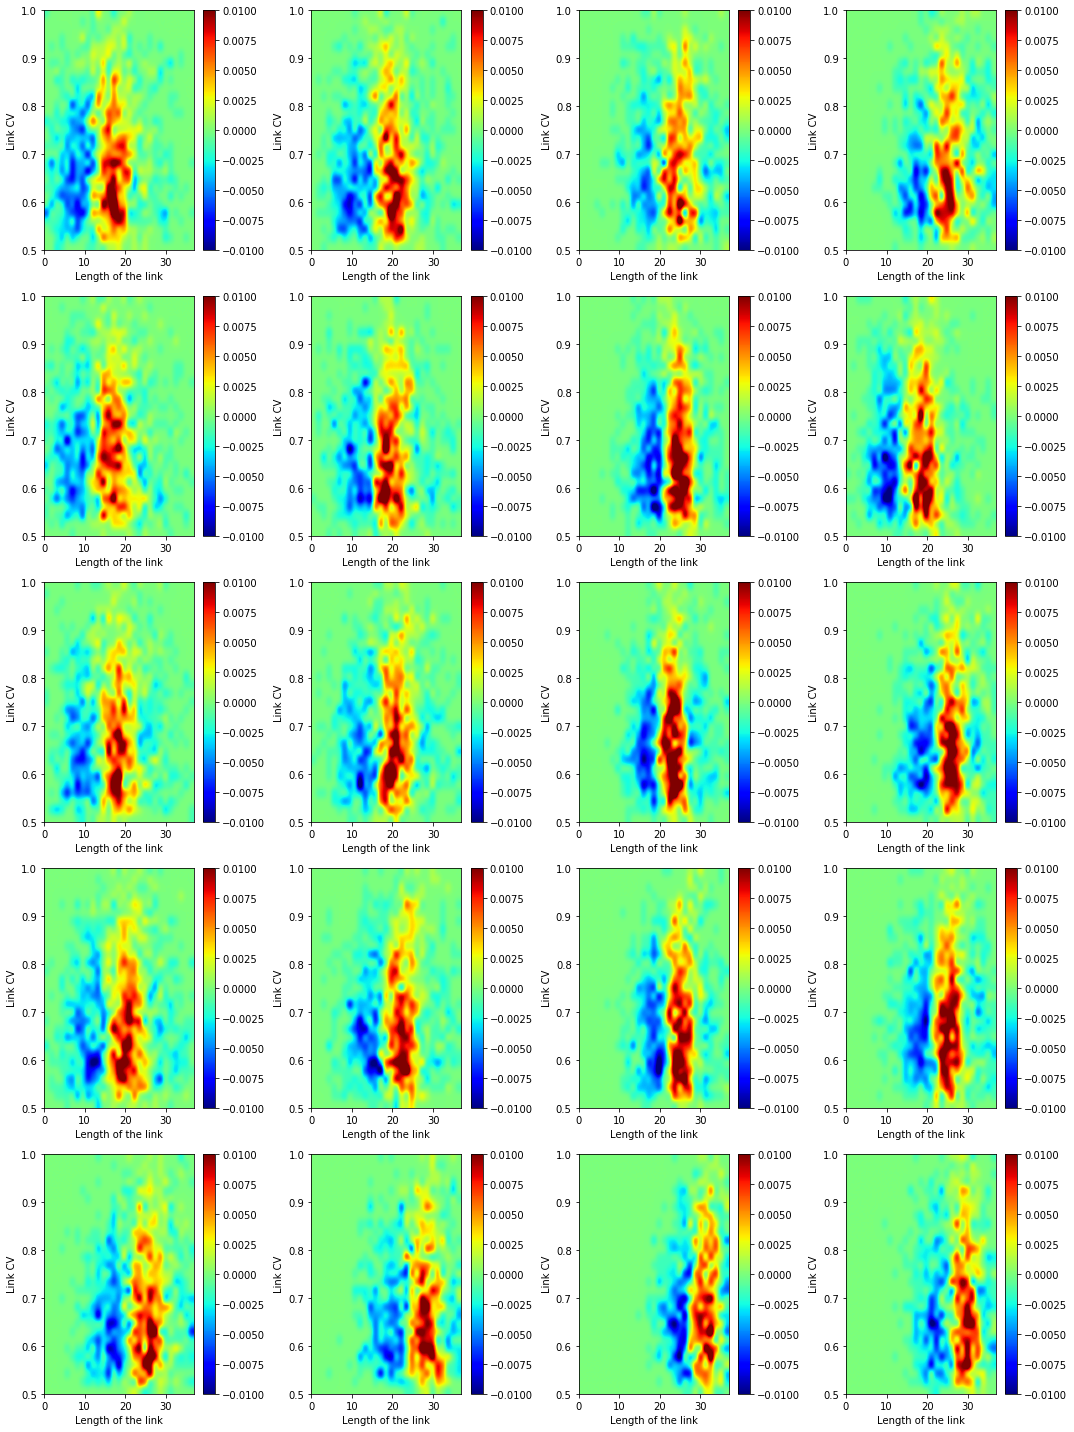

In [39]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        plt.subplot(len(bands), len(stages), count)
        # ODRT
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,s_mask[stages[i]]])
        H,xb,yb = np.histogram2d(d_eu, b[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        # FIXATION
        b_fx[stages[i]]  = np.apply_along_axis( count_activations, 1, STb_fix[:,j,s_mask_fix[stages[i]]])
        H_fx,xb_fx,yb_fx = np.histogram2d(d_eu, b_fx[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        # PLOTING
        plt.imshow(H-H_fx, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-0.01, vmax=0.01)
        plt.ylabel('Link CV')
        plt.colorbar()
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()

#### Links' correlation

In [40]:
CCij_fx = np.zeros([len(net.bands), net.session_info['nP'],net.session_info['nP'],len(stages)])
for b in tqdm( range(len(net.bands)) ):
    for s in range(len(stages)):
        CCij_fx[b,:,:,s] = np.corrcoef(STb_fix[:,b,s_mask_fix[stages[s]]].values, rowvar=True) 

100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


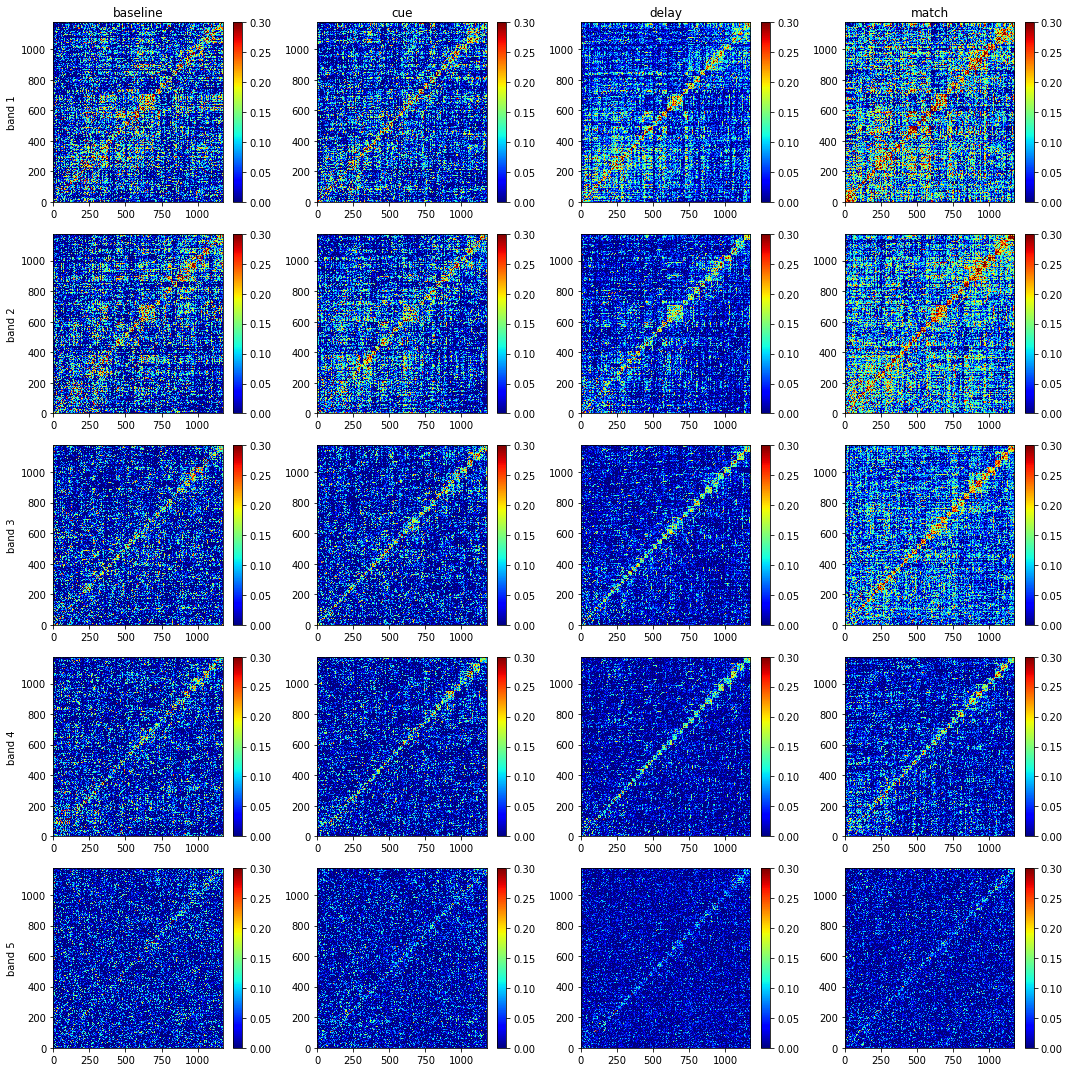

In [41]:
plt.figure(figsize=(15,15))
count = 1
for b in range(len(net.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        plt.imshow(CCij_fx[b,:,:,i], aspect='auto', cmap='jet', 
                   origin='lower', vmin=0,vmax=0.3)
        if b == 0: plt.title(stages[i])
        if i == 0: plt.ylabel(bands[b])
        plt.colorbar()
        count+=1
plt.tight_layout()

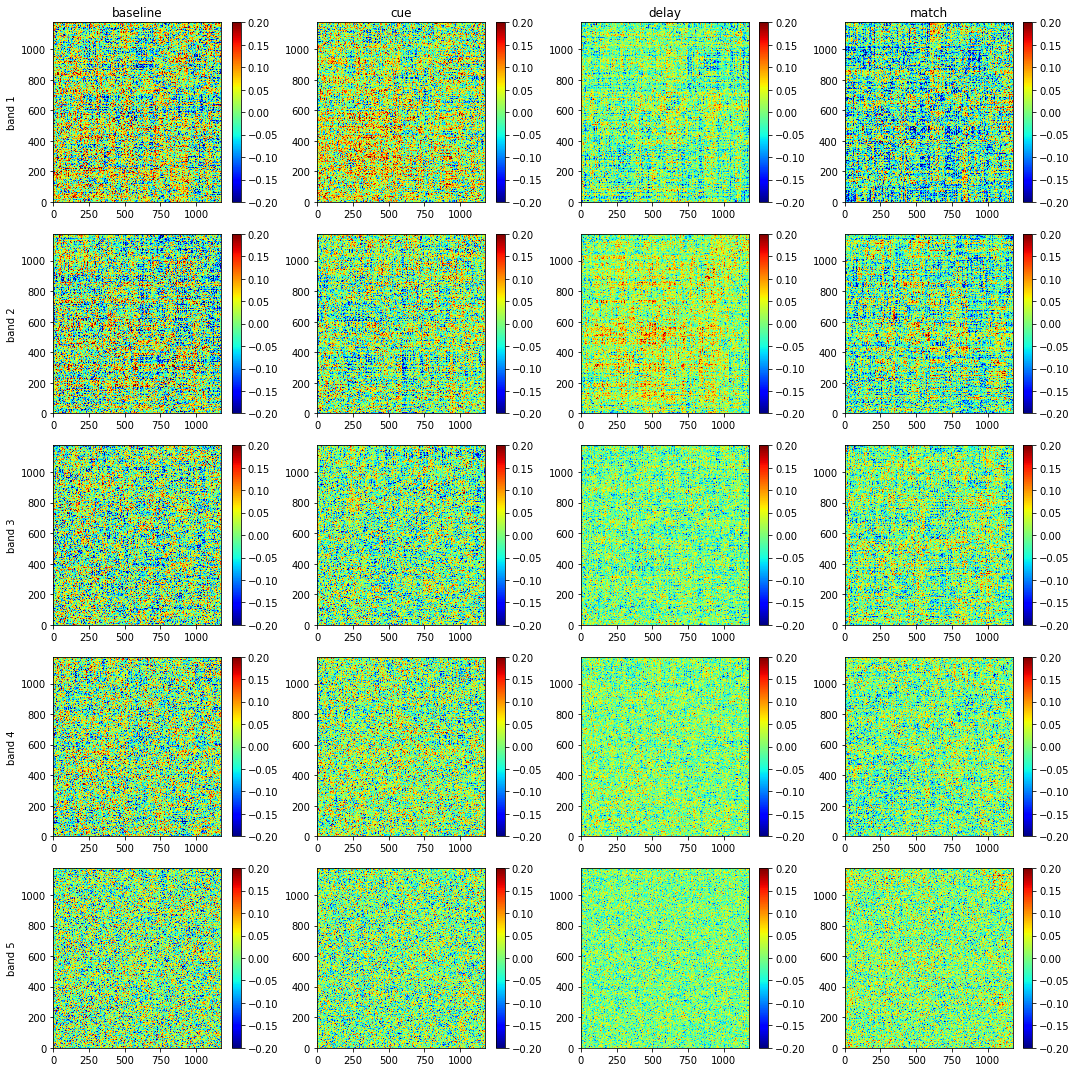

In [42]:
plt.figure(figsize=(15,15))
count = 1
for b in range(len(net.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        plt.imshow((CCij[b,:,:,i]-CCij_fx[b,:,:,i]), aspect='auto', cmap='jet', origin='lower',vmin=-0.2,vmax=0.2)
        if b == 0: plt.title(stages[i])
        if i == 0: plt.ylabel(bands[b])
        plt.colorbar()
        count+=1
plt.tight_layout()